### Import Necessary Libraries

In [1]:
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt
from scipy import interpolate
from scipy.optimize import differential_evolution, dual_annealing

### Variable Naming Scheme

In [2]:
# _df = dataframe
# rw = original data
# ep = data sorted by pipe angles (i.e. elevation profile)
# wd = reduced weld sizes i.e. 12.5 m
# ds = discretised data
# Del = delta values
# Pipe = OLGA Pipe
# Len = Length

#Examples:
# _dfrw = Dataframe with original data
# _dfep = Dataframe with elevation profile
# _Xrw = Original X Data
# _XrwDel = Original X Delta
# _Yrw = Original Y Data
# _YrwDel = Original Y Delta
# _LenRw = Original Length Data
# _PipeLenRw = Pipe Length Original Data

### Load Raw Profile Data

In [3]:
PATH = "../data"
_dfrw = pd.read_csv(f'{PATH}/profile.csv')

In [4]:
_dfrw.head(10)

,X,Y
0,0,-919.09
1,3,-919.07
2,6,-919.02
3,9,-919.01
4,12,-918.93
5,15,-918.97
6,18,-918.93
7,21,-918.85
8,24,-918.85
9,27,-918.80


In [5]:
_X_start = _dfrw['X'].iloc[0]
_X_end = _dfrw['X'].iloc[-1]
_Y_start = _dfrw['Y'].iloc[0]
_Y_end = _dfrw['Y'].iloc[-1]

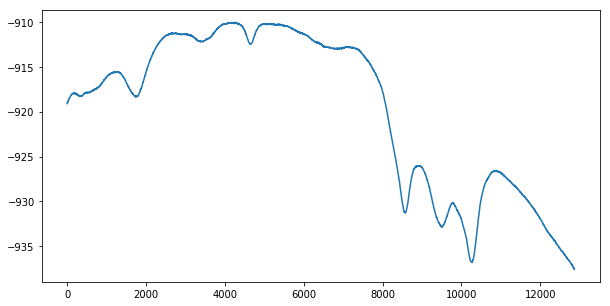

In [6]:
plt.figure(figsize=(10,5))
plt.plot(_dfrw['X'], _dfrw['Y'])
plt.show()

### Calculate Length and Elevation Change

In [7]:
#calculate delta X and delta y values
_dfrw['XrwDel'] = _dfrw['X'] - _dfrw['X'].shift(1)
_dfrw['YrwDel'] = _dfrw['Y'] - _dfrw['Y'].shift(1)

In [8]:
_dfrw.head(5)

,X,Y,XrwDel,YrwDel
0,0,-919.09,NaN,NaN
1,3,-919.07,3.0,0.02
2,6,-919.02,3.0,0.05
3,9,-919.01,3.0,0.01
4,12,-918.93,3.0,0.08


In [9]:
#Calculate length of each segment
_dfrw['PipeLenRw'] = np.sqrt(_dfrw['XrwDel']**2 + _dfrw['YrwDel']**2)

In [10]:
_dfrw.head(5)

,X,Y,XrwDel,YrwDel,PipeLenRw
0,0,-919.09,NaN,NaN,NaN
1,3,-919.07,3.0,0.02,3.000067
2,6,-919.02,3.0,0.05,3.000417
3,9,-919.01,3.0,0.01,3.000017
4,12,-918.93,3.0,0.08,3.001066


In [11]:
# calculate pipeline length
_dfrw['LenRw'] = _dfrw['PipeLenRw'].cumsum()
_dfrw.at[0, 'LenRw'] = 0

In [12]:
_dfrw.head(5)

,X,Y,XrwDel,YrwDel,PipeLenRw,LenRw
0,0,-919.09,NaN,NaN,NaN,0.000000
1,3,-919.07,3.0,0.02,3.000067,3.000067
2,6,-919.02,3.0,0.05,3.000417,6.000483
3,9,-919.01,3.0,0.01,3.000017,9.000500
4,12,-918.93,3.0,0.08,3.001066,12.001566


### Resample X Data to 12.5 m (Weld Distance) and Selected Discretisation Length

In [13]:
wd = 12.5 # Weld Distance
ds = 100 # Discretisation Length
_LenRw = _dfrw['LenRw'].values
_Yrw = _dfrw['Y'].values
f = interpolate.interp1d(_LenRw, _Yrw) # Scipy Interpolation Function
_Len_Total = _dfrw['LenRw'].iloc[-1] # Total Pipeline Length

In [14]:
_Lenwd = np.arange(0, _Len_Total, wd) # Reduced pipeline length to weld distance
_Lends = np.arange(0, _Len_Total, ds) # Reduced pipeline length to discretisation distance
_Lenwd[-1] = _Len_Total
_Lends[-1] = _Len_Total
_ywd = pd.Series(f(_Lenwd)) # Calculate y values for reduced length
_yds = pd.Series(f(_Lends)) # Calculate y values for reduced length
_Lenwd = pd.Series(_Lenwd)
_Lends = pd.Series(_Lends)

In [15]:
_dfrw['Lenwd'] = _Lenwd
_dfrw['Lends'] = _Lends
_dfrw['Ywd'] = _ywd
_dfrw['Yds'] = _yds

In [16]:
_dfrw.head(10)

,X,Y,XrwDel,YrwDel,PipeLenRw,LenRw,Lenwd,Lends,Ywd,Yds
0,0,-919.09,NaN,NaN,NaN,0.000000,0.0,0.0,-919.090000,-919.090000
1,3,-919.07,3.0,0.02,3.000067,3.000067,12.5,100.0,-918.936645,-918.143302
2,6,-919.02,3.0,0.05,3.000417,6.000483,25.0,200.0,-918.833388,-917.950134
3,9,-919.01,3.0,0.01,3.000017,9.000500,37.5,300.0,-918.680062,-918.219810
4,12,-918.93,3.0,0.08,3.001066,12.001566,50.0,400.0,-918.606650,-918.150000
5,15,-918.97,3.0,-0.04,3.000267,15.001833,62.5,500.0,-918.476621,-917.859738
6,18,-918.93,3.0,0.04,3.000267,18.002100,75.0,600.0,-918.330027,-917.759810
7,21,-918.85,3.0,0.08,3.001066,21.003166,87.5,700.0,-918.255084,-917.500345
8,24,-918.85,3.0,0.00,3.000000,24.003166,100.0,800.0,-918.143302,-917.233468
9,27,-918.80,3.0,0.05,3.000417,27.003583,112.5,900.0,-918.070064,-916.700311


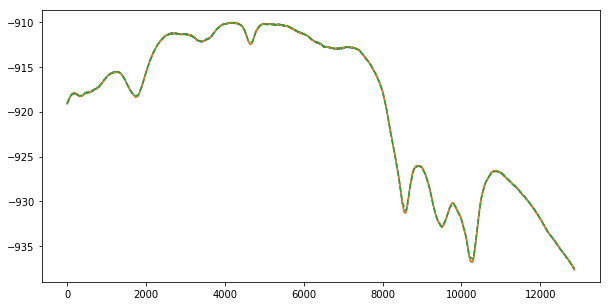

In [17]:
plt.figure(figsize=(10,5))
plt.plot(_dfrw['LenRw'], _dfrw['Y'])
plt.plot(_dfrw['Lenwd'], _dfrw['Ywd'], '-')
plt.plot(_dfrw['Lends'], _dfrw['Yds'], '--')
plt.show()

### Calculate Length and Angles

In [18]:
_dfrw['PipeLenwd'] = _dfrw['Lenwd'] - _dfrw['Lenwd'].shift(1)
_dfrw['YwdDel'] = _dfrw['Ywd'] - _dfrw['Ywd'].shift(1)
_dfrw['angleswd'] = np.arctan(_dfrw['YwdDel'] / _dfrw['PipeLenwd']) * 180 / 3.141592653589793
_dfrw['anglesrw'] = np.arctan(_dfrw['YrwDel'] / _dfrw['PipeLenRw']) * 180 / 3.141592653589793

In [19]:
_dfrw.head(5)

,X,Y,XrwDel,YrwDel,PipeLenRw,LenRw,Lenwd,Lends,Ywd,Yds,PipeLenwd,YwdDel,angleswd,anglesrw
0,0,-919.09,NaN,NaN,NaN,0.000000,0.0,0.0,-919.090000,-919.090000,NaN,NaN,NaN,NaN
1,3,-919.07,3.0,0.02,3.000067,3.000067,12.5,100.0,-918.936645,-918.143302,12.5,0.153355,0.702891,0.381958
2,6,-919.02,3.0,0.05,3.000417,6.000483,25.0,200.0,-918.833388,-917.950134,12.5,0.103257,0.473283,0.954709
3,9,-919.01,3.0,0.01,3.000017,9.000500,37.5,300.0,-918.680062,-918.219810,12.5,0.153326,0.702759,0.190984
4,12,-918.93,3.0,0.08,3.001066,12.001566,50.0,400.0,-918.606650,-918.150000,12.5,0.073413,0.336495,1.526983


C:\ProgramData\Anaconda3\envs\MachineLearning\lib\site-packages\numpy\lib\histograms.py:823: RuntimeWarning: invalid value encountered in true_divide
  return n/db/n.sum(), bin_edges


[]

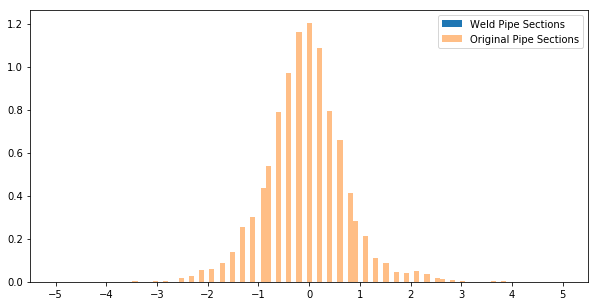

In [20]:
# Plot the Angle Class Chart
plt.figure(figsize=(10,5))
bins = np.linspace(-5, 5, 100)
plt.hist(_dfrw['angleswd']/_dfrw.count(), bins, density = True, label = 'Weld Pipe Sections')
plt.hist(_dfrw['anglesrw'], bins, alpha=0.5, density = True, label = 'Original Pipe Sections')
plt.legend(loc='upper right')
plt.xticks(np.arange(-5, 5+1, 1.0))
plt.plot()

In [21]:
_dfep = _dfrw[['PipeLenwd', 'YwdDel', 'angleswd']].copy()

### Sort by Acending Angles

In [22]:
_dfep[1:] = _dfep[1:].sort_values(by = 'angleswd').values

In [23]:
_dfep.head(10)

,PipeLenwd,YwdDel,angleswd
0,NaN,NaN,NaN
1,12.5,-0.455373,-2.086351
2,12.5,-0.428858,-1.964970
3,12.5,-0.427700,-1.959669
4,12.5,-0.406745,-1.863726
5,12.5,-0.392000,-1.796208
6,12.5,-0.384933,-1.763844
7,12.5,-0.377588,-1.730210
8,12.5,-0.375107,-1.718849
9,12.5,-0.362315,-1.660266


### Calculate the Elevation Profile

In [24]:
_dfep['Lenep'] = _dfep['PipeLenwd'].cumsum()
_dfep['Yep'] = _dfep['YwdDel'].cumsum() + _Y_start
_dfep.at[0, 'Lenep'] = 0
_dfep.at[0, 'Yep'] = _Y_start

In [25]:
_dfep.head(10)

,PipeLenwd,YwdDel,angleswd,Lenep,Yep
0,NaN,NaN,NaN,0.0,-919.090000
1,12.5,-0.455373,-2.086351,12.5,-919.545373
2,12.5,-0.428858,-1.964970,25.0,-919.974231
3,12.5,-0.427700,-1.959669,37.5,-920.401931
4,12.5,-0.406745,-1.863726,50.0,-920.808676
5,12.5,-0.392000,-1.796208,62.5,-921.200676
6,12.5,-0.384933,-1.763844,75.0,-921.585609
7,12.5,-0.377588,-1.730210,87.5,-921.963197
8,12.5,-0.375107,-1.718849,100.0,-922.338304
9,12.5,-0.362315,-1.660266,112.5,-922.700620


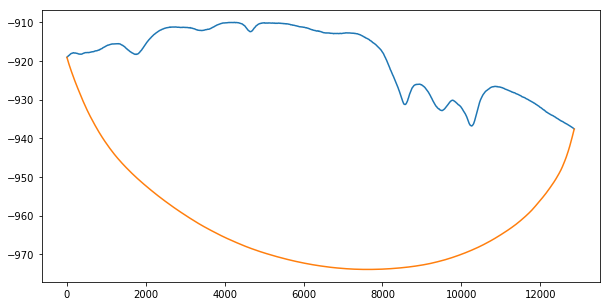

In [26]:
plt.figure(figsize=(10,5))
plt.plot(_dfrw['Lenwd'], _dfrw['Ywd'])
plt.plot(_dfep['Lenep'], _dfep['Yep'])
plt.show()

### Discretise the Elevation Profile

In [27]:
_Lenep = _dfep['Lenep'].dropna().values
_Yep = _dfep['Yep'].dropna().values
f = interpolate.interp1d(_Lenep, _Yep) # Scipy Interpolation Function
_Lends = np.arange(0, _Len_Total, ds) # Reduced pipeline length to discretisation distance
_Lends[-1] = _Len_Total
_yds = pd.Series(f(_Lends)) # Calculate y values for reduced length
_Lends = pd.Series(_Lends)
_dfep['Lends'] = _Lends
_dfep['Yds'] = _yds

In [28]:
_dfep.head(5)

,PipeLenwd,YwdDel,angleswd,Lenep,Yep,Lends,Yds
0,NaN,NaN,NaN,0.0,-919.090000,0.0,-919.090000
1,12.5,-0.455373,-2.086351,12.5,-919.545373,100.0,-922.338304
2,12.5,-0.428858,-1.964970,25.0,-919.974231,200.0,-925.152878
3,12.5,-0.427700,-1.959669,37.5,-920.401931,300.0,-927.721792
4,12.5,-0.406745,-1.863726,50.0,-920.808676,400.0,-930.178450


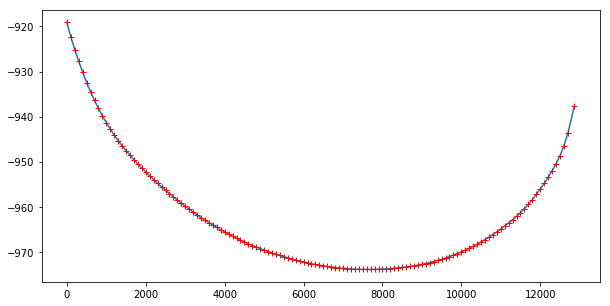

In [29]:
plt.figure(figsize=(10,5))
plt.plot(_dfep['Lenep'], _dfep['Yep'])
plt.plot(_dfep['Lends'], _dfep['Yds'], 'r+')
plt.show()

### Calculate Lengths and Angles

In [30]:
_dfep['PipeLends'] = _dfep['Lends'] - _dfep['Lends'].shift(1)
_dfep['YdsDel'] = _dfep['Yds'] - _dfep['Yds'].shift(1)
_dfep['anglesds'] = np.arctan(_dfep['YdsDel'] / _dfep['PipeLends']) * 180 / 3.141592653589793

In [31]:
_dfep.head(5)

,PipeLenwd,YwdDel,angleswd,Lenep,Yep,Lends,Yds,PipeLends,YdsDel,anglesds
0,NaN,NaN,NaN,0.0,-919.090000,0.0,-919.090000,NaN,NaN,NaN
1,12.5,-0.455373,-2.086351,12.5,-919.545373,100.0,-922.338304,100.0,-3.248304,-1.860487
2,12.5,-0.428858,-1.964970,25.0,-919.974231,200.0,-925.152878,100.0,-2.814574,-1.612206
3,12.5,-0.427700,-1.959669,37.5,-920.401931,300.0,-927.721792,100.0,-2.568914,-1.471555
4,12.5,-0.406745,-1.863726,50.0,-920.808676,400.0,-930.178450,100.0,-2.456658,-1.407278


[]

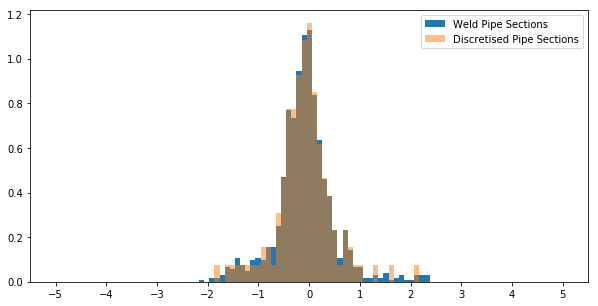

In [32]:
# Plot the Angle Class Chart
plt.figure(figsize=(10,5))
bins = np.linspace(-5, 5, 100)
plt.hist(_dfep['angleswd'], bins, density = True, label = 'Weld Pipe Sections')
plt.hist(_dfep['anglesds'], bins, density = True, alpha=0.5, label = 'Discretised Pipe Sections')
plt.legend(loc='upper right')
plt.xticks(np.arange(-5, 5+1, 1.0))
plt.plot()

### Optimise

In [33]:
_dfds = _dfep[['PipeLends', 'YdsDel', 'Lends', 'Yds']].copy()

In [34]:
_dfds.head(5)

,PipeLends,YdsDel,Lends,Yds
0,NaN,NaN,0.0,-919.090000
1,100.0,-3.248304,100.0,-922.338304
2,100.0,-2.814574,200.0,-925.152878
3,100.0,-2.568914,300.0,-927.721792
4,100.0,-2.456658,400.0,-930.178450


In [35]:
_dfds['PipeIdx'] = _dfds.index

In [36]:
_dfds.count()['PipeLends']

128

In [37]:
_dfds.head(5)

,PipeLends,YdsDel,Lends,Yds,PipeIdx
0,NaN,NaN,0.0,-919.090000,0
1,100.0,-3.248304,100.0,-922.338304,1
2,100.0,-2.814574,200.0,-925.152878,2
3,100.0,-2.568914,300.0,-927.721792,3
4,100.0,-2.456658,400.0,-930.178450,4


In [38]:
def optimise(pipeidx):
    pipeidx = pd.Series(pipeidx)
    _dfds['PipeIdx'] = pipeidx
    
    _dfds[1:] = _dfds[1:].sort_values(by = 'PipeIdx').values
    _dfds['Lends'] = _dfds['PipeLends'].cumsum()
    _dfds['Yds'] = _dfds['YdsDel'].cumsum() + _Y_start
    _dfds.at[0, 'Yds'] = _Y_start
    
    yds_new = _dfds['Yds'].dropna().values
    yds_old = _dfrw['Yds'].dropna().values
    mse = np.sum(np.sqrt((yds_old - yds_new)**2))
    return mse

In [39]:
pipeidx = np.arange(0, _dfds.count()['PipeIdx'], 1)

In [40]:
mse = optimise(pipeidx)

In [41]:
mse

5471.988093155112

In [42]:
bounds = [(0, _dfds.count()['PipeLends']) for i in range(0, _dfds.count()['PipeLends'])]

In [43]:
result = dual_annealing(optimise, bounds)

KeyboardInterrupt: 

In [44]:
_dfds

,PipeLends,YdsDel,Lends,Yds,PipeIdx
0,NaN,NaN,NaN,-919.090000,86.482105
1,100.0,-0.219369,100.0,-919.309369,0.062109
2,100.0,0.201306,200.0,-919.108063,0.088667
3,100.0,-0.761315,300.0,-919.869378,2.668077
4,100.0,-0.516400,400.0,-920.385778,4.770226
5,100.0,1.564475,500.0,-918.821303,7.594409
6,100.0,-1.028990,600.0,-919.850293,7.698968
7,100.0,-0.276448,700.0,-920.126741,8.068602
8,100.0,-2.269968,800.0,-922.396709,8.633206
9,100.0,-1.779864,900.0,-924.176573,9.237216


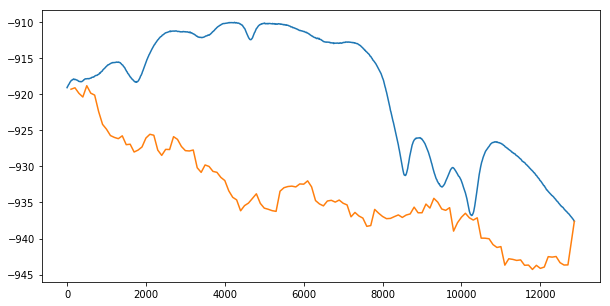

In [45]:
plt.figure(figsize=(10,5))
plt.plot(_dfrw['Lenwd'], _dfrw['Ywd'])
plt.plot(_dfds['Lends'], _dfds['Yds'])
plt.show()